In [17]:
import pandas as pd
import os
def get_csv_data(video_folder_name, fileName):    
    data = pd.read_csv(fileName, sep=';')
    data.columns = ['ID', 'file_name', 'cut_frame']
    file_paths = []
    for entry in data.iloc():
        file_paths.append(video_folder_name + entry['file_name'])
    data['file_path'] = file_paths
    data.set_index('ID', inplace=True, drop=True)
#     data["cut_frame"] = pd.to_numeric(data["cut_frame"])
    return data


def get_videos_from_folder(video_folder_name):
    video_files = []
    for root, dirs, files in os.walk(video_folder_name):
        for filename in files:
            if '.mp4' in filename:
                video_files.append({"file_name": filename, "file_path": video_folder_name + filename})
    data = pd.DataFrame(video_files, columns=['file_name', 'file_path'])
    return data

training = get_csv_data('../WS2020_DeepLearning_Videos/Task2_Training_Validation/', '../Task2_Training.csv')
test = get_csv_data('../WS2020_DeepLearning_Videos/Task2_Test/', '../Task2_Test.csv')

training.dropna(inplace=True)
test.dropna(inplace=True)

display(training)
display(test)

,file_name,cut_frame,file_path
ID,,,
1,_8Vy3dlHg2w_00132.mp4,63.0,../WS2020_DeepLearning_Videos/Task2_Training_V...
2,_8Vy3dlHg2w_00133.mp4,25.0,../WS2020_DeepLearning_Videos/Task2_Training_V...
3,_8Vy3dlHg2w_00136.mp4,71.0,../WS2020_DeepLearning_Videos/Task2_Training_V...
4,_8Vy3dlHg2w_00139.mp4,35.0,../WS2020_DeepLearning_Videos/Task2_Training_V...
5,_8Vy3dlHg2w_00142.mp4,20.0,../WS2020_DeepLearning_Videos/Task2_Training_V...
...,...,...,...
296,_tigfCJFLZg_00285.mp4,51.0,../WS2020_DeepLearning_Videos/Task2_Training_V...
297,_tigfCJFLZg_00286.mp4,130.0,../WS2020_DeepLearning_Videos/Task2_Training_V...
298,_tigfCJFLZg_00289.mp4,52.0,../WS2020_DeepLearning_Videos/Task2_Training_V...


,file_name,cut_frame,file_path
ID,,,
1,_tigfCJFLZg_00293.mp4,131.0,../WS2020_DeepLearning_Videos/Task2_Test/_tigf...
2,_tigfCJFLZg_00295.mp4,85.0,../WS2020_DeepLearning_Videos/Task2_Test/_tigf...
3,_tigfCJFLZg_00298.mp4,93.0,../WS2020_DeepLearning_Videos/Task2_Test/_tigf...
4,_tigfCJFLZg_00299.mp4,138.0,../WS2020_DeepLearning_Videos/Task2_Test/_tigf...
5,_tigfCJFLZg_00301.mp4,124.0,../WS2020_DeepLearning_Videos/Task2_Test/_tigf...
...,...,...,...
86,_tigfCJFLZg_00428.mp4,45.0,../WS2020_DeepLearning_Videos/Task2_Test/_tigf...
87,_tigfCJFLZg_00429.mp4,125.0,../WS2020_DeepLearning_Videos/Task2_Test/_tigf...
88,_tigfCJFLZg_00430.mp4,49.0,../WS2020_DeepLearning_Videos/Task2_Test/_tigf...


In [107]:
import cv2
import numpy as np
import math

class_names = ['wet', 'dry']
from scipy.ndimage import rotate

def get_augmented_frames(frame):
#     rotated_frame = rotate(frame, 30)
    flipped_frame = cv2.flip(frame, 1)
    # rotieren
    # farben anpassen
    # skalieren
    # flip
    # zoom
    # ...
    return [flipped_frame]

def preprocess_frame(frame):
    frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
    frame = cv2.resize(frame, (64,64))
    ## delete 20% of frames around cut frame
    ## filter out zoomed videos _8V...00159.mp4
    return frame

def get_label_for_frame(frame_number, cut_frame):
    if(frame_number >= cut_frame):
        return 0
    else:
        return 1

def calculate_frame_ratio(totalFrames, cutFrame):
    upperRatio = (totalFrames - cutFrame) / totalFrames
    lowerRatio = cutFrame / totalFrames
    return lowerRatio if upperRatio > lowerRatio else upperRatio

def get_frames_labels(data):
    frames = []
    labels = []
    augmented_frames = []
    augmented_labels = []
    for file in data.iloc():
        file_path = file['file_path']
        cutframe = file['cut_frame']
        
        # Playing video from file:
        cap = cv2.VideoCapture(file['file_path'])
        totalFrames = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
        frame_ratio = calculate_frame_ratio(totalFrames, cutframe)
        minimumFrame = math.ceil(cutframe - (frame_ratio * totalFrames))
        maximumFrame = math.floor(cutframe + (frame_ratio * totalFrames))
#         print(f"Video {file['file_name']}, totalFrames: {totalFrames}, ratio: {frame_ratio}, min: {minimumFrame}, max: {maximumFrame}")
        currentFrame = 0
        success, frame = cap.read()

        while(success):
            
            if currentFrame < minimumFrame or currentFrame > maximumFrame:
                currentFrame += 1
                success, frame = cap.read()
                continue
    
            label = get_label_for_frame(currentFrame, cutframe)
            frame = preprocess_frame(frame)
            
            current_augmented_frames = get_augmented_frames(frame)
            augmented_frames = augmented_frames + current_augmented_frames
            for i in current_augmented_frames:
                augmented_labels.append(label)

            frames.append(frame)
            labels.append(label)

            currentFrame += 1
            success, frame = cap.read()
            
        cap.release()
        cv2.destroyAllWindows()
    return (frames, labels, augmented_frames, augmented_labels)

training_frames, training_labels, augmented_training_frames, augmented_training_labels = get_frames_labels(training)
test_frames, test_labels, augmented_test_frames, augmented_test_labels = get_frames_labels(test)

(35058, 128, 128, 3)
(9192, 64, 64, 3)


array([1, 1, 1, ..., 0, 0, 0])

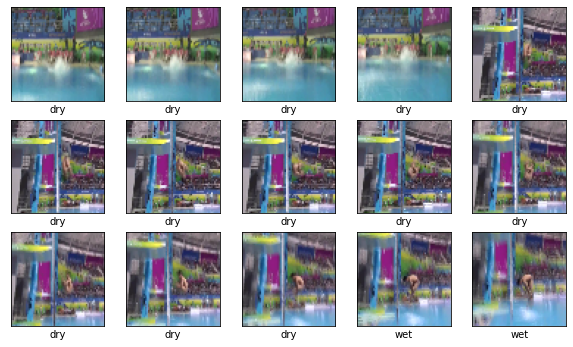

In [108]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

training_frames = training_frames + augmented_training_frames
training_labels = training_labels + augmented_training_labels

test_frames = test_frames + augmented_test_frames
test_labels = test_labels + augmented_test_labels

x_train, x_validation, y_train, y_validation = train_test_split(np.array(training_frames), np.array(training_labels), test_size=0.33, random_state=42)
test_images = np.array(test_frames)
test_labels = np.array(test_labels)

print(train_images.shape)
print(test_images.shape)
display(train_labels)
plt.figure(figsize=(10,10))
first_image = 50
last_image = 65
for i in range(first_image, last_image):
    plt.subplot(5,5,i-first_image+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(augmented_training_frames[i], cmap=plt.cm.binary)
    # The CIFAR labels happen to be arrays, 
    # which is why you need the extra index
    plt.xlabel(class_names[train_labels[i]])
plt.show()

In [145]:
from tensorflow.keras import layers, models, regularizers

model = models.Sequential()
model.add(layers.Conv2D(32, (3, 3), activation='relu', input_shape=(64,64, 3)))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(64, (3, 3), activation='relu'))
# model.add(layers.Flatten(input_shape=(128,128)))
model.add(layers.Flatten())
model.add(layers.Dense(64, activation='relu'))
model.add(layers.Dense(4))
model.summary()

Model: "sequential_24"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_45 (Conv2D)           (None, 62, 62, 32)        896       
_________________________________________________________________
max_pooling2d_22 (MaxPooling (None, 31, 31, 32)        0         
_________________________________________________________________
conv2d_46 (Conv2D)           (None, 29, 29, 64)        18496     
_________________________________________________________________
flatten_23 (Flatten)         (None, 53824)             0         
_________________________________________________________________
dense_46 (Dense)             (None, 64)                3444800   
_________________________________________________________________
dense_47 (Dense)             (None, 4)                 260       
Total params: 3,464,452
Trainable params: 3,464,452
Non-trainable params: 0
___________________________________________

In [146]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

history = model.fit(x_train, y_train, epochs=10, 
                    validation_data=(x_validation, y_validation))

Epoch 1/10
630/630 [==============================] - 3s 5ms/step - loss: 3.6864 - accuracy: 0.9265 - val_loss: 0.1024 - val_accuracy: 0.9615
Epoch 2/10
630/630 [==============================] - 3s 5ms/step - loss: 0.0877 - accuracy: 0.9701 - val_loss: 0.1114 - val_accuracy: 0.9596
Epoch 3/10
630/630 [==============================] - 3s 5ms/step - loss: 0.0723 - accuracy: 0.9730 - val_loss: 0.1044 - val_accuracy: 0.9592
Epoch 4/10
630/630 [==============================] - 3s 5ms/step - loss: 0.0767 - accuracy: 0.9720 - val_loss: 0.0872 - val_accuracy: 0.9639
Epoch 5/10
630/630 [==============================] - 3s 5ms/step - loss: 0.0686 - accuracy: 0.9722 - val_loss: 0.1097 - val_accuracy: 0.9631
Epoch 6/10
630/630 [==============================] - 3s 5ms/step - loss: 0.3743 - accuracy: 0.9202 - val_loss: 0.3791 - val_accuracy: 0.8366
Epoch 7/10
630/630 [==============================] - 3s 5ms/step - loss: 0.1751 - accuracy: 0.9397 - val_loss: 0.1216 - val_accuracy: 0.9543
Epoch 

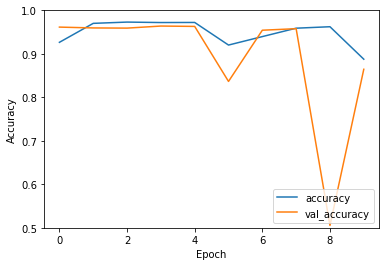

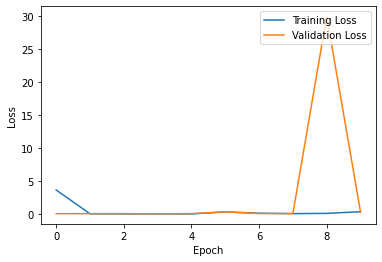

288/288 - 1s - loss: 0.3556 - accuracy: 0.8578
Test Accuracy: 0.8578111529350281, Test Loss: 0.3556320071220398


In [147]:
plt.plot(history.history['accuracy'], label='accuracy')
plt.plot(history.history['val_accuracy'], label = 'val_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.ylim([0.5, 1])
plt.legend(loc='lower right')
plt.show()

plt.plot(history.history['loss'], label="Training Loss")
plt.plot(history.history['val_loss'], label="Validation Loss")
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(loc='upper right')
plt.show()

test_loss, test_acc = model.evaluate(test_images,  test_labels, verbose=2)
print(f"Test Accuracy: {test_acc}, Test Loss: {test_loss}")

1. Input Video handling
2. Layer anpassen

In [32]:
from functools import reduce
def predict_video(path):
    # Playing video from file:
    images_of_video = []
    cap = cv2.VideoCapture(path)
    success, frame = cap.read()

    while(success):
        frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
        frame = cv2.resize(frame, (256,256))
        images_of_video.append(frame)
        # Capture frame by frame
        success, frame = cap.read()
    cap.release()
    cv2.destroyAllWindows()
    
    images_of_video = np.array(images_of_video)
    
    predictions = model.predict(images_of_video)
    
    predictions = tf.nn.softmax(predictions)
    
    predicted_labels = [class_names[np.argmax(prediction)] for prediction in predictions]
    
    most_frequent_label = max(set(predicted_labels), key = predicted_labels.count)
    
    frequent_label_index = class_names.index(most_frequent_label)
    
    mean_score = 0
    for prediction in predictions:
        score = prediction
        mean_score += score[frequent_label_index]
    mean_score = mean_score / len(predictions)
    
    print(
        """
         File: {} 
         predicted perspective: {} 
         confidence: {:.2f}%
         """
        .format(path, most_frequent_label, 100 * mean_score)
    )
    


predict_video('../WS2020_DeepLearning_Videos/Task2_Test/_tigfCJFLZg_00314.mp4')


         File: ../WS2020_DeepLearning_Videos/Task2_Test/_tigfCJFLZg_00314.mp4 
         predicted perspective: dry 
         confidence: 78.94%
         


In [13]:
import os

video_folder = "../WS2020_DeepLearning_Videos/Task2_Test/"
for root, dirs, files in os.walk(video_folder):
    for filename in files:
        if '.mp4' in filename:
            predict_video(f"{video_folder}/{filename}")


         File: ../WS2020_DeepLearning_Videos/Task2_Test//_tigfCJFLZg_00351.mp4 
         predicted perspective: Side 
         confidence: 81.17%
         

         File: ../WS2020_DeepLearning_Videos/Task2_Test//_tigfCJFLZg_00317.mp4 
         predicted perspective: Side 
         confidence: 68.13%
         

         File: ../WS2020_DeepLearning_Videos/Task2_Test//_tigfCJFLZg_00374.mp4 
         predicted perspective: Side 
         confidence: 90.89%
         

         File: ../WS2020_DeepLearning_Videos/Task2_Test//_tigfCJFLZg_00377.mp4 
         predicted perspective: Side 
         confidence: 70.19%
         

         File: ../WS2020_DeepLearning_Videos/Task2_Test//_tigfCJFLZg_00354.mp4 
         predicted perspective: Side 
         confidence: 72.31%
         

         File: ../WS2020_DeepLearning_Videos/Task2_Test//_tigfCJFLZg_00328.mp4 
         predicted perspective: Side 
         confidence: 67.53%
         

         File: ../WS2020_DeepLearning_Videos/Task2_Test//


         File: ../WS2020_DeepLearning_Videos/Task2_Test//_tigfCJFLZg_00330.mp4 
         predicted perspective: Side 
         confidence: 79.58%
         

         File: ../WS2020_DeepLearning_Videos/Task2_Test//_tigfCJFLZg_00327.mp4 
         predicted perspective: Side 
         confidence: 75.03%
         

         File: ../WS2020_DeepLearning_Videos/Task2_Test//_tigfCJFLZg_00337.mp4 
         predicted perspective: Side 
         confidence: 86.67%
         

         File: ../WS2020_DeepLearning_Videos/Task2_Test//_tigfCJFLZg_00320.mp4 
         predicted perspective: Side 
         confidence: 86.19%
         

         File: ../WS2020_DeepLearning_Videos/Task2_Test//_tigfCJFLZg_00384.mp4 
         predicted perspective: Side 
         confidence: 79.32%
         

         File: ../WS2020_DeepLearning_Videos/Task2_Test//_tigfCJFLZg_00345.mp4 
         predicted perspective: Side 
         confidence: 74.08%
         

         File: ../WS2020_DeepLearning_Videos/Task2_Test//

Conv2D


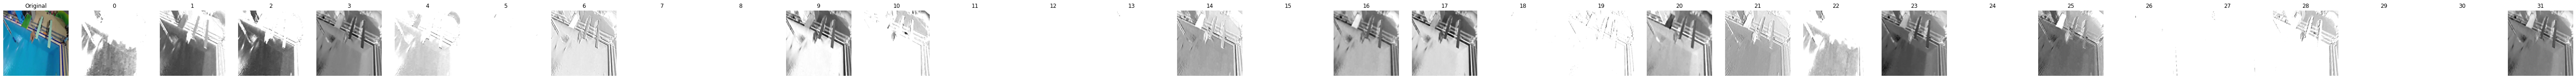

MaxPooling2D


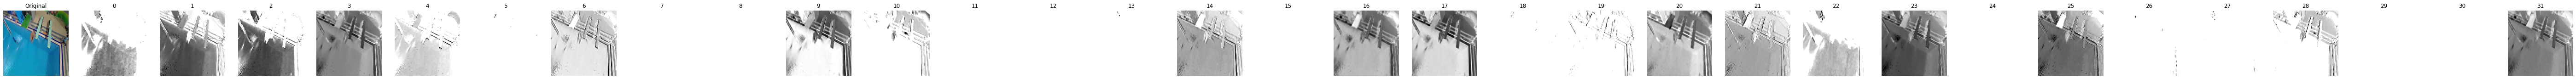

Conv2D


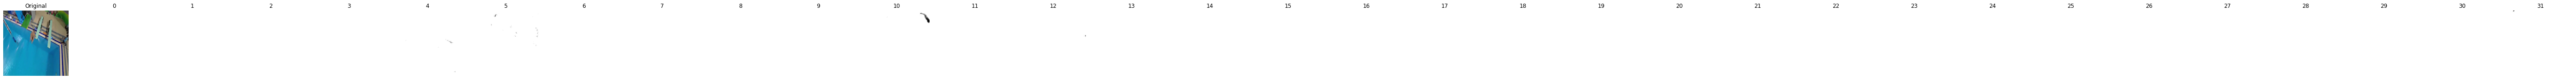

In [15]:
from tensorflow.keras import backend as K


def show_layer_for_image(layer, image):
    my_image = test_images[image]
    my_image_raw = np.squeeze(my_image)
    image = np.expand_dims(my_image, axis=0)
    layer = model.get_layer(index = layer)
    print(type(layer).__name__)
    convolutions = K.function(model.inputs, [layer.output])([image])
    #kick out empty axes
    convolutions = np.squeeze(convolutions)
    #rearange the order so that we can iterate over the images
    convolutions = np.transpose(convolutions)
    width = 33
    fig = plt.figure(figsize=(100, 100))
    # draw the original pic first
    ax = fig.add_subplot(1, width, 1)
    ax.axis('off')
    ax.title.set_text("Original")
    ax.imshow(my_image_raw, interpolation='sinc' , cmap='binary')
    # draw some examples for filter results
    for index, filter in enumerate(convolutions):
        if index == width - 1:
            break
        ax = fig.add_subplot(1, width, index + 2)
        ax.axis('off')
        ax.title.set_text(index)
        ax.imshow(filter.transpose(), interpolation = 'sinc', cmap='binary')
    plt.show()
    plt.close()
show_layer_for_image(0, 180)
show_layer_for_image(1, 180)
show_layer_for_image(2, 180)